# TalkingData AdTracking Fraud Detection Challenge

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

# Comments / Thoughs 

The IP addresses is encoded, because of data protection. Also looking at IP location is a bad idea because of the same IP doesn't mean it is from the same user. Especially if this is mobile operator. Most IP are shared, your phone most likely behind several (layered) NAT before its address exposed to internet.
[See here](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/51650)

But a user may be defined with a combination of IP, Device and OS

IP address did have a lot of nearness information. But we prefer kagglers to build a model without nearness information, because in China, IP address is highly unstable, user's IP can vary from time to time. [See more](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/51348)

# Working with big dataset on 16GB RAM

While working with largeee dataset as in this assignment with close to 200 millions data points we need to be smart with how me manage our data in the memory. While I have a MSI GS63VR laptop with i7-7700HQ, Nvidia GTX 1060 and 16GB RAM, that is a pretty high-end computer, 16GB RAM won't be enough to not overloading allocated RAM while working on the dataset.

After a couple hours on google and stackoverflow I came a cross [this notebook](https://www.kaggle.com/yuliagm/how-to-work-with-big-datasets-on-16g-ram-dask) that actually was published on the TalkingData AdTracking Fraud Detection Challenge that I'm working on in this assigment. The notebook contains 7 pro-tip on how to work on bigdata with limited resources.

- Tip 1 - Deleting unused variables and gc.collect()
- Tip 2 - Presetting the datatypes
- Tip 3 - Importing selected rows of a csv file
- Tip 4 - Importing in batches and processing each individually
- Tip 5 - Importing just selected columns
- Tip 6 - Creative data processing
- Tip 7 - Using Dask or Pandas on Ray

## Tip 1 - Deleting unused variables and gc.collect()
Python do have a nice garbage collector. But while working on huge dataset you can clean up the memory by deleting unused temporary variables.
For example if you have a variable `only_used_once` you can delete it by `del only_used_once`.
But even after deleting the variable there could be residual memory, so by using the garbage collector manually by importing it in the top of your project with `import gc`, you can call `gc.collect()` every time you want to free up some memory.

## Tip 2 - Presetting the datatypes
With pandas `read_csv` python will try to guess what datatype you are trying to load in to the memory. By defining the datatypes before importing, you can avoid that python is allocating more space than it needs to. Because Python will do that by default to avoid errors.
```python
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        }

X_train = pd.read_csv('train.csv', dtype=dtypes)
```

## Tip 3 - Importing selected rows of a csv file
Importing 200 millions rows at once will allocate almost all the memory on my computer, by selecting a specified number of rows to import we can avoid that. Then we can do our analyse and look at the data before we go on to analyse the whole dataset.
```python
X_train = pd.read_csv('train.csv', nrows=10000)
```
We can also skip rows, the reason we may do that is to look at other ranges in the dataset. By specifing `skiprows=range(1, 500000)` we can skip the first 500 000 rows in the data set. and by using range we still can keep the first row as our headings.

By using the `skiprows` we can also generate our own random sampling. 

```python
#generate list of lines to skip
skiplines = np.random.choice(np.arange(1, lines), size=lines-1-1000000, replace=False)

#sort the list
skiplines=np.sort(skiplines)

# Import the randomly selected 1 million rows
train = pd.read_csv('../input/train.csv', skiprows=skiplines, dtype=dtypes)

# Delete useless `skipline` list and free up memory
del skiplines
gc.collect()
```

## Tip 4 - Importing on batches and processing each individually

When we want to analyse or do some processing on the whole dataset we can't get it into the memory without over allocation the memory. A solution to that is to do the work in batches. We use chunk's of data, that we specify the size of. We then do some work on each chunk util there are no more chunk's left. Then we have worked over the whole dataset.

The example under is for analyzing the `is_attributed` attribute. We loop through the dataset chunk by chunk and then we can filter out the clicks that was attributed (`is_attributed==1` => the app was downloaded) into a separate dataframe for futher inspection.

```python
#set up an empty dataframe
df_converted = pd.DataFrame()

#we are going to work with chunks of size 1 million rows
chunksize = 10 ** 6

#in each chunk, filter for values that have 'is_attributed'==1, and merge these values into one dataframe
for chunk in pd.read_csv('train.csv', chunksize=chunksize, dtype=dtypes):
    filtered = (chunk[(np.where(chunk['is_attributed']==1, True, False))])
    df_converted = pd.concat([df_converted, filtered], ignore_index=True, )

```

We can then run `df_converted.info()` to see that there is `x` entries for when the app was downloaded.


# Tip 5 - Importing just selected columns
Importing just two fields instead of the whole table is a much better approach for optimalizating the memory allocation. By using the `usecols` in `read_csv` we can achieve that.

```python
#wanted columns
columns = ['ip', 'click_time', 'is_attributed']
dtypes = {
        'ip'            : 'uint32',
        'is_attributed' : 'uint8',
        }

ips_df = pd.read_csv('train.csv', usecols=columns, dtype=dtypes)
```

# Tip 6 - Creative data processing
The kernel cannot handle groupby on the whole dataframe, But it can do it in sections. So we can calculate counts in batches, merge them and sum up to total counts.

```python
size=100000
all_rows = len(ips_df)
num_parts = all_rows//size

#generate the first batch
ip_counts = ips_df[0:size][['ip', 'is_attributed']].groupby('ip', as_index=False).count()

#add remaining batches
for p in range(1,num_parts):
    start = p*size
    end = p*size + size
    if end < all_rows:
        group = ips_df[start:end][['ip', 'is_attributed']].groupby('ip', as_index=False).count()
    else:
        group = ips_df[start:][['ip', 'is_attributed']].groupby('ip', as_index=False).count()
    ip_counts = ip_counts.merge(group, on='ip', how='outer')
    ip_counts.columns = ['ip', 'count1','count2']
    ip_counts['counts'] = np.nansum((ip_counts['count1'], ip_counts['count2']), axis = 0)
    ip_counts.drop(columns=['count1', 'count2'], axis = 0, inplace=True)
```

# Tip 7 - Using Dask or Pandas on Ray
With Dask you will need to change the code. But with Ray you can use it as normal Pandas.
- [Dask - Dataframe](http://docs.dask.org/en/latest/dataframe.html)
- [Padas on ray](https://ray.readthedocs.io/en/latest/installation.html)

Example with Padas on Ray:
```python
#import pandas as pd
import ray.dataframe as pd
X_train = pd.read_csv(train.csv)
```

# Setup

In [2]:
# To suppress some warnings below. Nothing important, just to make some outputs cleaner.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [20]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
import matplotlib
import sklearn

In [22]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

# Get the data

In [23]:
train_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_cols  = ['ip', 'app', 'device', 'os', 'channel', 'click_time']

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

X_train = pd.read_csv('datasets/train.csv', skiprows=range(1,5000000),nrows=1000000, dtype=dtypes, header=0)
# X_train = pd.read_csv('datasets/train.csv', dtype=dtypes, header=0)

In [24]:
X_train.shape

(10000000, 8)

In [25]:
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,37363,12,1,25,245,2017-11-06 20:27:57,NaN,0
1,89913,2,1,9,469,2017-11-06 20:27:57,NaN,0
2,114235,26,1,13,121,2017-11-06 20:27:57,NaN,0
3,18839,3,1,19,442,2017-11-06 20:27:57,NaN,0
4,105580,15,1,13,245,2017-11-06 20:27:57,NaN,0


# Data Fields

Each row of the training data contains a click record, with the following features.

- `ip`: ip address of click.
- `app`: app id for marketing.
- `device`: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- `os`: os version id of user mobile phone
- `channel`: channel id of mobile ad publisher
- `click_time`: timestamp of click (UTC)
- `attributed_time`: if user download the app for after clicking an ad, this is the time of the app download
- `is_attributed`: the target that is to be predicted, indicating the app was downloaded

Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

- `click_id`: reference for making predictions
- `is_attributed`: not included

# Creating Features

# Extracting time information
Extracting day, hour, minute and second from the `click_time`

In [10]:
#time
X_train['hour']    = pd.to_datetime(X_train.click_time).dt.hour.astype('uint8')
X_train['day']     = pd.to_datetime(X_train.click_time).dt.day.astype('uint8')
X_train['wday']    = pd.to_datetime(X_train.click_time).dt.dayofweek.astype('uint8')
X_train['minute']  = pd.to_datetime(X_train.click_time).dt.minute.astype('uint8')
X_train['second']  = pd.to_datetime(X_train.click_time).dt.second.astype('uint8')
X_train["doy"]     = pd.to_datetime(X_train.click_time).dt.dayofyear.astype('uint8')
X_train            = X_train.drop(['click_time', 'attributed_time'], axis=1)
print(X_train.dtypes) 

ip               uint32
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
hour              uint8
day               uint8
wday              uint8
minute            uint8
second            uint8
doy               uint8
dtype: object


In [11]:
X_train.head()

,ip,app,device,os,channel,is_attributed,hour,day,wday,minute,second,doy
0,37363,12,1,25,245,0,20,6,0,27,57,54
1,89913,2,1,9,469,0,20,6,0,27,57,54
2,114235,26,1,13,121,0,20,6,0,27,57,54
3,18839,3,1,19,442,0,20,6,0,27,57,54
4,105580,15,1,13,245,0,20,6,0,27,57,54


In [16]:
frequent_hour = X_train.hour.value_counts().sort_index()
frequent_day = X_train.day.value_counts().sort_index()
frequent_doy = X_train.doy.value_counts().sort_index()
frequent_wday = X_train.wday.value_counts().sort_index()
frequent_minute = X_train.minute.value_counts().sort_index()
frequent_second = X_train.second.value_counts().sort_index()

In [17]:
#print("Frequent hours\n", frequent_hour)
# print("Frequent days\n", frequent_day)
# print("Frequent doy\n", frequent_doy)
# print("Frequent week days\n", frequent_wday)
# print("Frequent minutes\n", frequent_minute)
# print("Frequent seconds\n", frequent_second)

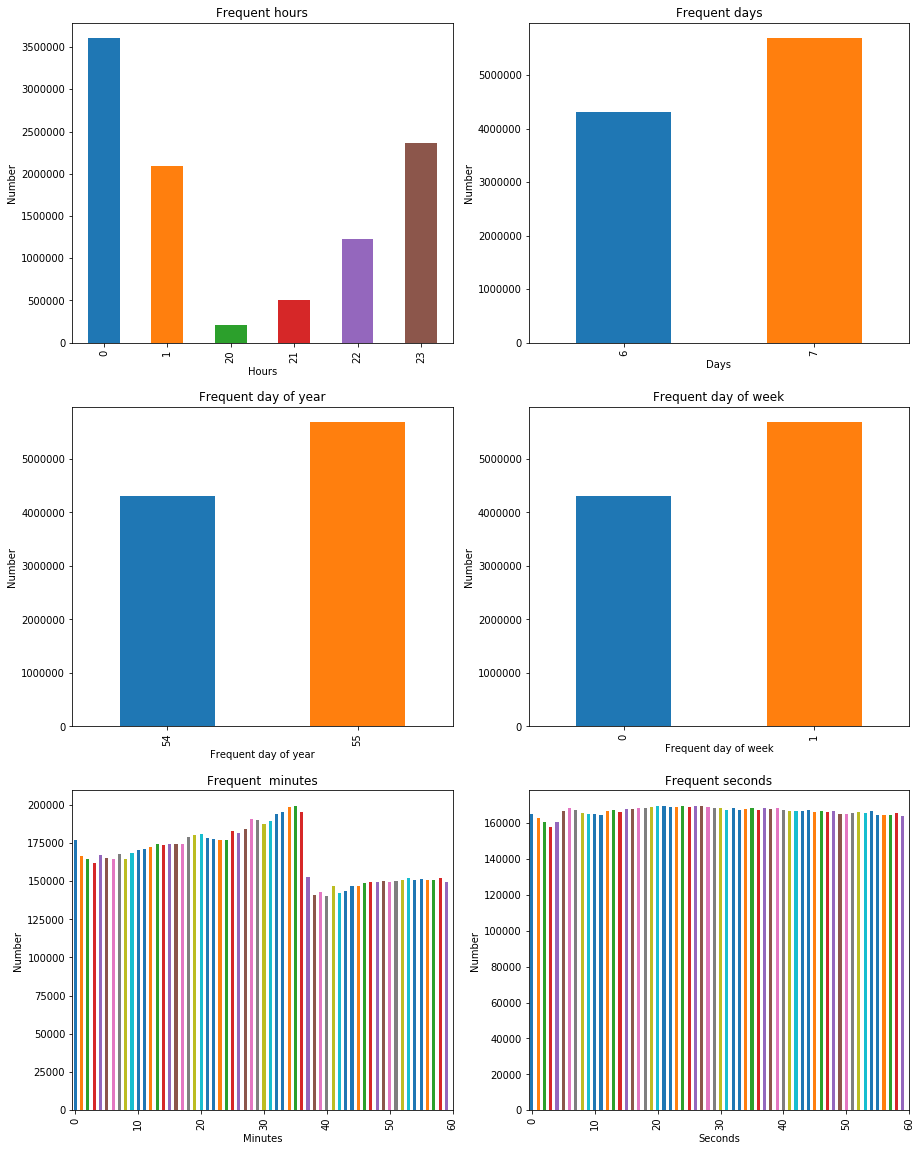

In [18]:
plt.figure(figsize=(15,20))

plt.subplot(321)
frequent_hour.plot(kind='bar')
plt.title("Frequent hours")
plt.xlabel("Hours")
plt.ylabel("Number")

plt.subplot(322)
frequent_day.plot(kind='bar')
plt.title("Frequent days")
plt.xlabel("Days")
plt.ylabel("Number")

plt.subplot(323)
frequent_doy.plot(kind='bar')
plt.title("Frequent day of year")
plt.xlabel("Frequent day of year")
plt.ylabel("Number")

plt.subplot(324)
frequent_wday.plot(kind='bar')
plt.title("Frequent day of week")
plt.xlabel("Frequent day of week")
plt.ylabel("Number")

plt.subplot(325)
frequent_minute.plot(kind='bar')
plt.xticks(np.arange(0, 69, step=10), (0,10,20,30,40,50,60))
plt.title("Frequent  minutes")
plt.xlabel("Minutes")
plt.ylabel("Number")

plt.subplot(326)
frequent_second.plot(kind='bar')
plt.xticks(np.arange(0, 69, step=10), (0,10,20,30,40,50,60))
plt.title("Frequent seconds")
plt.xlabel("Seconds")
plt.ylabel("Number")

# Free up memory and call garbage collector
del frequent_hour,frequent_day,frequent_doy,frequent_wday,frequent_minute,frequent_second
gc.collect()

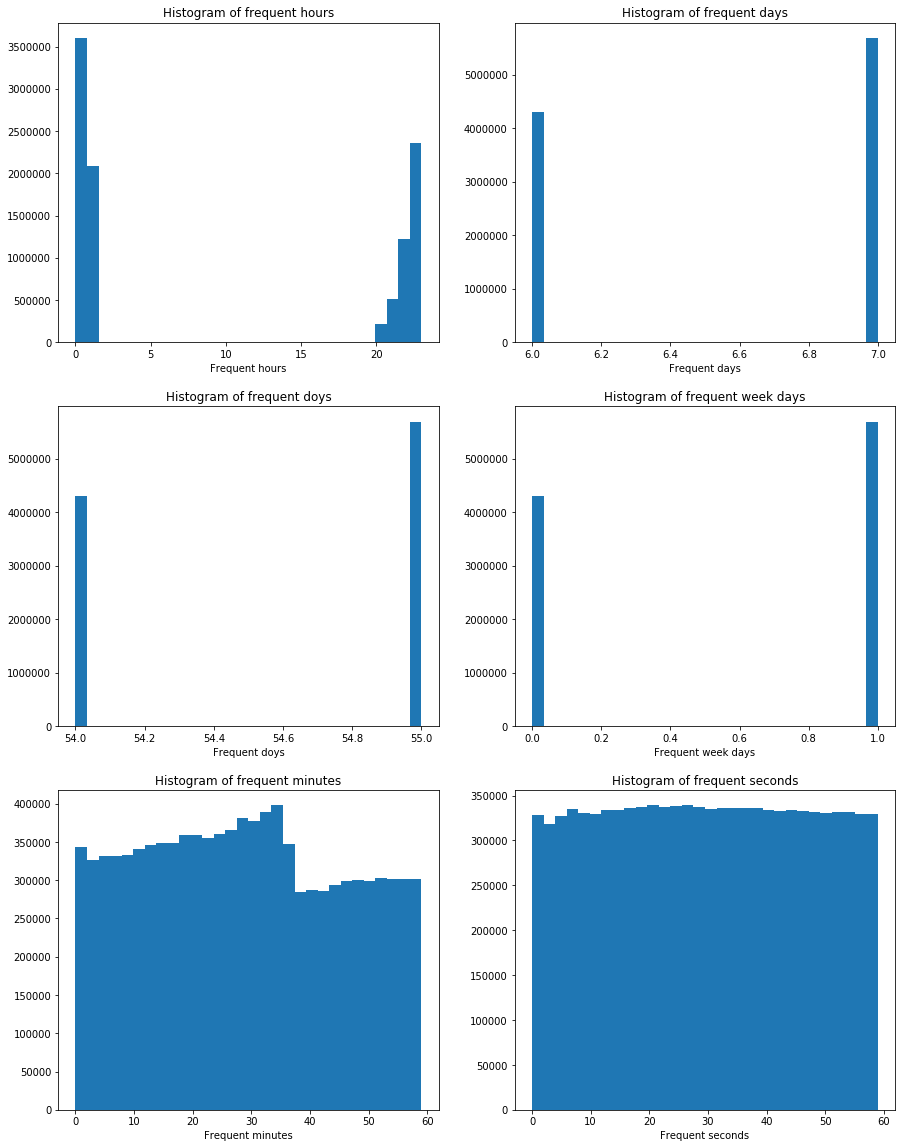

In [19]:
BIN = 30
plt.figure(figsize=(15,20))
plt.subplot(321)
plt.hist(X_train['hour'], bins=BIN)
plt.title("Histogram of frequent hours")
plt.xlabel("Frequent hours")

plt.subplot(322)
plt.hist(X_train['day'], bins=BIN)
plt.title("Histogram of frequent days")
plt.xlabel("Frequent days")

plt.subplot(323)
plt.hist(X_train['doy'], bins=BIN)
plt.title("Histogram of frequent doys")
plt.xlabel("Frequent doys")

plt.subplot(324)
plt.hist(X_train['wday'], bins=BIN)
plt.title("Histogram of frequent week days")
plt.xlabel("Frequent week days")

plt.subplot(325)
plt.hist(X_train['minute'], bins=BIN)
plt.title("Histogram of frequent minutes")
plt.xlabel("Frequent minutes")

plt.subplot(326)
plt.hist(X_train['second'], bins=BIN)
plt.title("Histogram of frequent seconds")
plt.xlabel("Frequent seconds")
plt.show()